<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/V3_4_COMPAS_Clustering_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import math
import scipy.stats as stats
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

# UTILS (all)

## Sets of Features (aka data columns)

In [3]:
#Master Dataset
META_COL = ['clusters', 'new_clusters']
META_COL_VIZ = ['Error_Type']

ERROR_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
BASIC_COL = ['age', 'decile_score', 'priors_count']
DUMMY_COL = ['sex_Female','race_African-American', 'race_Caucasian', 'race_Asian', 'race_Hispanic',
                      'race_Native American', 'race_Other']

ERROR_COL_scaled = ['errors_scaled'] #, 'TP_scaled', 'TN_scaled', 'FN_scaled', 'FP_scaled']
BASIC_COL_scaled = ['age_scaled', 'decile_score_scaled', 'priors_count_scaled']
DUMMY_COL_scaled = ['sex_Female_scaled', 'race_Native American_scaled','race_Other_scaled',
                'race_African-American_scaled', 'race_Asian_scaled', 'race_Caucasian_scaled', 'race_Hispanic_scaled']
DUMMY_COL_scaled_light = ['sex_Female_scaled', 'race_African-American_scaled', 'race_Caucasian_scaled']

#SHAP is created on BASIC_COL_scaled and DUMMY_COL_scaled
SHAP_BASIC = ['Shap_age', 'Shap_decile_score', 'Shap_priors_count']
SHAP_DUMMY = ['Shap_sex_Female','Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
                         'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other']

SHAP_BASIC_scaled = ['Shap_age_scaled', 'Shap_decile_score_scaled', 'Shap_priors_count_scaled']
SHAP_DUMMY_scaled = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled',
                     'Shap_race_Asian_scaled', 'Shap_race_Caucasian_scaled','Shap_race_Hispanic_scaled',
                     'Shap_race_Native American_scaled', 'Shap_race_Other_scaled']
SHAP_DUMMY_scaled_light = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled','Shap_race_Caucasian_scaled']

## DATA PREP UTILS

In [4]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def subset_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def subset_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

In [5]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

## UTILS FOR CLUSTERING

In [7]:
# Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error() from V1
# Does not work on scaled (binary) error features
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty set')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

In [8]:
def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
  if(len(banned_clusters) != 0):
    filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)
    all_cluster_ids = all_cluster_ids[filter_tf]

  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1:
      continue

    #print ('This is the next cluster:', candidate_cluster_id)

    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]

    if len(candidate_cluster) < min_size:
      #print('...it is too small:', len(candidate_cluster))
      continue
    else:
      return(candidate_cluster_id)

  #print('No suitable clusters were found!')
  return(-1)

## UTILS for VIZ

In [160]:
def tsne_plot_wClusters(data, title, perplexity, learning_rate, n_iter, alpha, tsne_columns):

  # Extract features for t-SNE and drop other_columns
  tsne_features = data[tsne_columns]
  other_columns = [col for col in data.columns if col not in tsne_features]
  other_features = data[other_columns]

  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
  tsne_result = tsne.fit_transform(tsne_features)
  tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

  temp_dataset = tsne_df.join(other_features, how='left')

  # Create scatterplot using seaborn
  scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
  scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  plt.show()

# LOAD DATA

In [12]:
data_shaper = pd.read_csv('https://raw.githubusercontent.com/MDankloff/ClusterCompas/main/Compas_error_shap.csv')

In [13]:
data_shaper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                2495 non-null   float64
 1   decile_score                       2495 non-null   float64
 2   priors_count                       2495 non-null   float64
 3   sex_Female                         2495 non-null   float64
 4   race_African-American              2495 non-null   float64
 5   race_Asian                         2495 non-null   float64
 6   race_Caucasian                     2495 non-null   float64
 7   race_Hispanic                      2495 non-null   float64
 8   race_Native American               2495 non-null   float64
 9   race_Other                         2495 non-null   float64
 10  age_scaled                         2495 non-null   float64
 11  decile_score_scaled                2495 non-null   float

In [14]:
data_shaper.head()

,age,decile_score,priors_count,sex_Female,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,...,Shap_race_Asian_scaled,Shap_race_Caucasian_scaled,Shap_race_Hispanic_scaled,Shap_race_Native American_scaled,Shap_race_Other_scaled,errors_scaled,TP_scaled,TN_scaled,FN_scaled,FP_scaled
0,33.0,4.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.212022,-0.028428,0.297156,0.049157,0.329638,1.303607,-0.575723,-0.783884,2.014923,-0.457088
1,34.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.028091,0.751564,-1.452893,0.049157,-0.328178,-0.767102,1.736948,-0.783884,-0.496297,-0.457088
2,30.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.106145,0.325008,-0.065022,0.049157,0.032566,1.303607,-0.575723,-0.783884,2.014923,-0.457088
3,31.0,10.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.067103,0.123069,0.007584,0.049157,0.170190,-0.767102,-0.575723,1.275699,-0.496297,-0.457088
4,34.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.048034,0.499824,0.172228,0.049157,0.012654,-0.767102,-0.575723,1.275699,-0.496297,-0.457088


# PREPARE DATA

In [15]:
# Split into TP/FN and TN/FP
TPFN_data = subset_TP_FN(data_shaper)
TNFP_data = subset_TN_FP(data_shaper)

In [16]:
# Drop NA's
TPFN_data = TPFN_data.dropna()
TNFP_data = TNFP_data.dropna()

# K-MEANS CLUSTERING

In [18]:
def hbac_kmeans(data, columns_to_use=[], error='errors',
                min_splittable_cluster_prop = 0.05,
                min_acceptable_cluster_prop = 0.03,
                min_acceptable_error_diff = 0.01,
                max_iter=300):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
      # Init temporary cluster
      data['new_clusters'] = None

      ### Select the cluster to split in 2
      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
      if(x == -1):
        break

      candidate_cluster = data.copy(deep=True)
      candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

      #### SPLIT IN 2 SUB-CLUSTERS
      kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[columns_to_use])
      candidate_cluster['new_clusters'] = kmeans.predict(candidate_cluster[columns_to_use])

      # KEEP CLUSTER OR NOT
      # ...are cluster size large enough?
      l0 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      l1 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if((l0 < min_acceptable_cluster_size) | (l1 < min_acceptable_cluster_size)):
        #print('Bad split: too small')
        banned_clusters.append(x)
        continue

      # ...is error rate difference large enough?
      e0 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      e1 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if(abs(e0 - e1) < min_acceptable_error_diff):
        #print('Bad split: same error')
        banned_clusters.append(x)
        continue

      ### Re-integrate to main data
      data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

      # Make new Cluster IDs
      new_id = data['clusters'].unique().max() + 1
      data.loc[((data.clusters == x) & (data.new_clusters == 1)), 'clusters'] = new_id

    #print('Max iterations reached:', i)
    return data

In [285]:
def apply_hbac_kmeans(data,
                      columns_to_use = ERROR_COL_scaled + BASIC_COL_scaled + DUMMY_COL_scaled,
                      error='errors',
                      min_splittable_cluster_prop = 0.02,
                      min_acceptable_cluster_prop = 0.02,
                      min_acceptable_error_diff = 0.01,
                      max_iter=100):

  res_all = hbac_kmeans(data=data,
                        columns_to_use = columns_to_use,
                        error=error,
                        min_splittable_cluster_prop = min_splittable_cluster_prop,
                        min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                        min_acceptable_error_diff = min_acceptable_error_diff,
                        max_iter=max_iter)

  # MAKE RECAP of cluster info
  # ...with error rates
  res = res_all[['clusters', 'errors']]

  # ...with cluster size
  temp = res_all[['clusters']]
  temp['count'] = 1
  recap = temp.groupby(['clusters'], as_index=False).sum()

  # ...with number of error
  recap['n_error'] = res.groupby(['clusters']).sum().astype(int)

  # ...with 1-vs-All error diff
  recap['error_rate'] = res.groupby(['clusters']).mean()
  recap['std'] = (recap['error_rate'] * (1-recap['error_rate']))/recap['count']
  recap['std'] = recap['std'].apply(np.sqrt)

  # Prepare Quality metrics
  diff_vs_rest = []
  diff_std = []
  diff_p =[]

  race_aa_prop = []
  race_aa_diff = []
  race_aa_p = []

  race_c_prop = []
  race_c_diff = []
  race_c_p = []

  female_prop = []
  female_diff = []
  female_p = []

  for c in recap['clusters']:
    # Get in-cluster data
    c_data = data.loc[data['clusters'] == c]
    c_count = recap['count'][c]

    # Get out-of-cluster data
    rest_data = data.loc[data['clusters'] != c]
    # Check if no other cluster
    if(len(rest_data) == 0):
      diff_vs_rest.append(np.nan)
      diff_std.append(np.nan)
      diff_p.append(np.nan)

      race_aa_prop.append(np.nan)
      race_aa_diff.append(np.nan)
      race_aa_p.append(np.nan)

      race_c_prop.append(np.nan)
      race_c_diff.append(np.nan)
      race_c_p.append(np.nan)

      female_prop.append(np.nan)
      female_diff.append(np.nan)
      female_p.append(np.nan)
      break

    rest_recap = recap.loc[recap['clusters'] != c]
    rest_count = rest_recap['count'].sum()

    #### Quick test: differences in error rates
    # Get error rate difference 1-vs-rest
    rest_n_error = rest_recap['n_error'].sum()
    rest_rate = rest_n_error / rest_count
    diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

    # ...with std deviation of error differences
    std_rest = (rest_rate * (1-rest_rate))/rest_count
    std_rest = np.sqrt(std_rest)
    diff_std.append(recap['std'][c] + std_rest)

    # ...with Poisson stat testprint('Zero!')
    # Deal with splits with 0 error (by using either number of errors (FN or FP), or number of correct classifications (TP or TN))
    if((recap['n_error'][c] < 1) | (recap['count'][c] < 1) | (rest_n_error < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c], rest_count - rest_n_error, rest_count)
      diff_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
      diff_p.append(round(res.pvalue, 3))

    ##### Sensitive features (gender, race) -- ['sex_Female', 'race_African-American', 'race_Caucasian']]
    ### Race African-American (AA)
    rest_n_aa = rest_data['race_African-American'].sum()
    rest_prop_aa = rest_n_aa / rest_count

    c_n_aa = c_data['race_African-American'].sum()
    c_prop_aa = c_n_aa / c_count

    race_aa_prop.append(c_prop_aa)
    race_aa_diff.append(c_prop_aa - rest_prop_aa)

    # Deal with splits with 0 African-American (by using either number of AA, or number of non-AA)
    if((c_n_aa < 1) | (c_count < 1) | (rest_n_aa < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_aa, c_count, rest_count - rest_n_aa, rest_count)
      race_aa_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_aa, c_count, rest_n_aa, rest_count)
      race_aa_p.append(round(res.pvalue, 3))

    ### Race Caucasian
    rest_n_c = rest_data['race_Caucasian'].sum()
    rest_prop_c = rest_n_c / rest_count

    c_n_c = c_data['race_Caucasian'].sum()
    c_prop_c = c_n_c / c_count

    race_c_prop.append(c_prop_c)
    race_c_diff.append(c_prop_c - rest_prop_c)

    # Deal with splits with 0 African-American (by using either number of AA, or number of non-AA)
    if((c_n_c < 1) | (c_count < 1) | (rest_n_c < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_c, c_count, rest_count - rest_n_c, rest_count)
      race_c_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_c, c_count, rest_n_c, rest_count)
      race_c_p.append(round(res.pvalue, 3))

    ##### Gender
    rest_n_female = rest_data['sex_Female'].sum()
    rest_prop_female = rest_n_female/ rest_count

    c_n_female = c_data['sex_Female'].sum()
    c_prop_female = c_n_female / c_count

    female_prop.append(c_prop_female)
    female_diff.append(c_prop_female - rest_prop_female)

    # Deal with splits with 0 females(by using either number of females, or number of males)
    if((c_n_female < 1) | (c_count < 1) | (rest_n_female < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_female, c_count, rest_count - rest_n_female, rest_count)
      female_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_female, c_count, rest_n_female, rest_count)
      female_p.append(round(res.pvalue, 3))


  print(c+1, ' clusters were found:')
  recap['diff_vs_rest'] = np.around(diff_vs_rest, 3)
  recap['diff_std'] = np.around(diff_std, 3)
  recap['diff_p'] = diff_p

  recap['race_aa_prop'] = np.around(race_aa_prop, 3)
  recap['race_aa_diff'] = np.around(race_aa_diff, 3)
  recap['race_aa_p'] = race_aa_p

  recap['race_c_prop'] = np.around(race_c_prop, 3)
  recap['race_c_diff'] = np.around(race_c_diff, 3)
  recap['race_c_p'] = race_c_p

  recap['female_prop'] = np.around(female_prop, 3)
  recap['female_diff'] = np.around(female_diff, 3)
  recap['female_p'] = female_p


  recap['error_rate'] = np.around(recap['error_rate'] , 3)
  recap['std'] = np.around(recap['std'] , 3)

  recap.rename(columns={'clusters':'c'}, inplace=True)
  #print(recap.sort_values(by=['diff_p']))

  return({'res': res_all, 'recap': recap})

# RESULTS (quick stats)


In [248]:
# Experiment's parameters
min_splittable_cluster_prop = 0.04
min_acceptable_cluster_prop = 0.03
min_acceptable_error_diff = 0.01

## Baseline (w/wo Error)

In [249]:
res_baseline = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = BASIC_COL_scaled + DUMMY_COL_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

17  clusters were found:


In [250]:
res_baseline['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
2,2,68,58,0.853,0.043,0.570,0.055,0.000,0.926,0.491,0.001,0.000,-0.386,0.004,0.0,-0.232,0.064
6,6,162,90,0.556,0.039,0.277,0.052,0.000,0.759,0.339,0.000,0.000,-0.416,0.000,0.0,-0.250,0.003
10,10,86,34,0.395,0.053,0.090,0.065,0.197,0.000,-0.489,0.000,1.000,0.674,0.000,0.0,-0.236,0.036
5,5,233,83,0.356,0.031,0.055,0.045,0.195,0.884,0.510,0.000,0.000,-0.441,0.000,0.0,-0.265,0.000
1,1,42,15,0.357,0.074,0.048,0.086,0.609,0.833,0.386,0.015,0.000,-0.379,0.023,1.0,0.803,0.002
0,0,72,24,0.333,0.056,0.024,0.068,0.732,0.000,-0.484,0.001,1.000,0.667,0.000,0.0,-0.233,0.056
7,7,67,22,0.328,0.057,0.019,0.070,0.794,0.000,-0.482,0.001,1.000,0.664,0.000,1.0,0.818,0.000
11,11,58,14,0.241,0.056,-0.072,0.069,0.282,0.000,-0.479,0.002,1.000,0.660,0.000,0.0,-0.231,0.088
13,13,57,12,0.211,0.054,-0.104,0.067,0.106,1.000,0.564,0.001,0.000,-0.383,0.008,0.0,-0.230,0.091
4,4,66,13,0.197,0.049,-0.119,0.062,0.046,0.985,0.552,0.000,0.000,-0.386,0.004,1.0,0.818,0.000


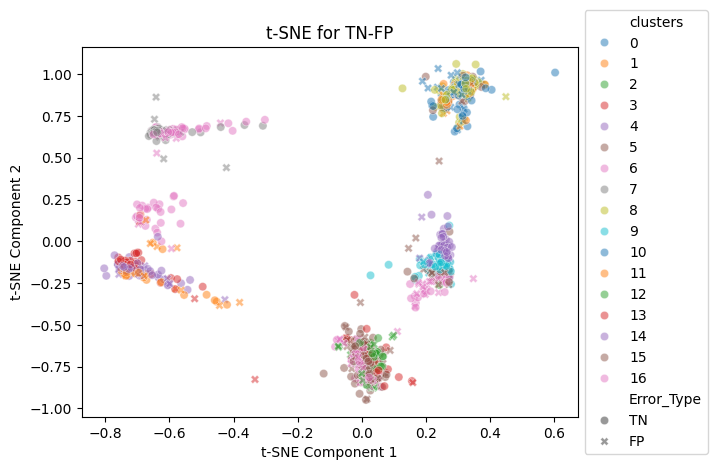

In [251]:
tsne_plot_wClusters(res_baseline['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

In [252]:
res_baseline_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + BASIC_COL_scaled + DUMMY_COL_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

17  clusters were found:


In [253]:
res_baseline_wError['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
5,5,72,55,0.764,0.050,0.478,0.062,0.000,0.917,0.482,0.000,0.000,-0.388,0.003,0.0,-0.233,0.056
12,12,88,60,0.682,0.050,0.396,0.062,0.000,0.761,0.322,0.002,0.000,-0.392,0.001,0.0,-0.236,0.034
6,6,133,67,0.504,0.043,0.214,0.056,0.002,0.699,0.265,0.001,0.000,-0.406,0.000,0.0,-0.244,0.008
11,11,63,26,0.413,0.062,0.107,0.075,0.200,0.000,-0.481,0.001,1.000,0.662,0.000,0.0,-0.231,0.075
0,0,46,17,0.370,0.071,0.061,0.084,0.505,0.000,-0.475,0.005,1.000,0.654,0.001,1.0,0.805,0.001
4,4,119,37,0.311,0.042,0.001,0.055,0.993,0.966,0.554,0.000,0.000,-0.402,0.000,0.0,-0.242,0.013
10,10,90,25,0.278,0.047,-0.035,0.060,0.546,0.000,-0.491,0.000,1.000,0.676,0.000,0.0,-0.236,0.032
13,13,109,28,0.257,0.042,-0.058,0.055,0.257,0.000,-0.498,0.000,0.706,0.367,0.000,0.0,-0.240,0.017
2,2,96,24,0.250,0.044,-0.065,0.057,0.227,0.948,0.525,0.000,0.000,-0.395,0.001,1.0,0.836,0.000
16,16,98,24,0.245,0.043,-0.070,0.056,0.182,1.000,0.582,0.000,0.000,-0.395,0.001,0.0,-0.238,0.025


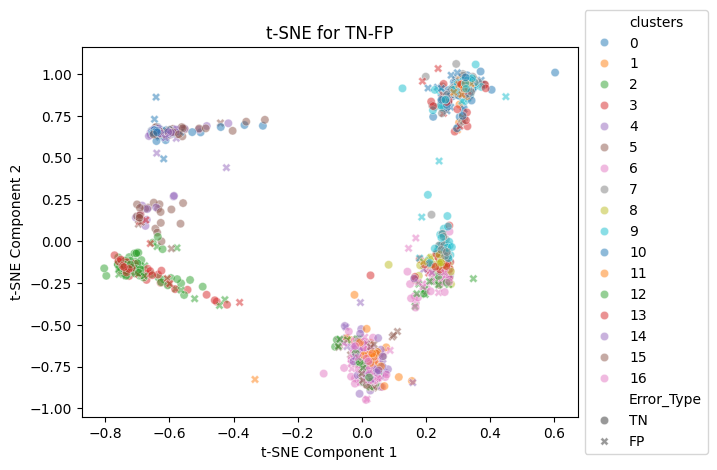

In [254]:
tsne_plot_wClusters(res_baseline_wError['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

## Regular + SHAP (w/wo Error)

In [255]:
res_wSHAP = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light ,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

14  clusters were found:


In [256]:
res_wSHAP['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
2,2,90,61,0.678,0.049,0.393,0.062,0.000,0.889,0.459,0.000,0.000,-0.393,0.001,0.000,-0.236,0.032
6,6,117,71,0.607,0.045,0.323,0.058,0.000,0.863,0.441,0.000,0.000,-0.401,0.000,0.000,-0.241,0.013
11,11,100,43,0.430,0.050,0.129,0.062,0.062,0.870,0.442,0.000,0.000,-0.396,0.000,0.000,-0.238,0.023
4,4,56,22,0.393,0.065,0.086,0.078,0.317,0.750,0.303,0.017,0.000,-0.383,0.009,0.000,-0.230,0.094
13,13,60,20,0.333,0.061,0.024,0.073,0.756,0.983,0.548,0.001,0.000,-0.384,0.007,0.000,-0.231,0.083
10,10,92,29,0.315,0.048,0.005,0.061,0.933,0.000,-0.492,0.000,1.000,0.677,0.000,0.000,-0.237,0.030
8,8,73,20,0.274,0.052,-0.038,0.065,0.546,0.000,-0.485,0.000,0.712,0.364,0.002,1.000,0.822,0.000
0,0,50,12,0.240,0.060,-0.073,0.073,0.310,0.000,-0.476,0.004,0.000,-0.381,0.013,0.000,-0.229,0.114
3,3,82,19,0.232,0.047,-0.084,0.059,0.137,1.000,0.574,0.000,0.000,-0.391,0.002,1.000,0.828,0.000
5,5,71,15,0.211,0.048,-0.104,0.061,0.074,0.901,0.466,0.001,0.000,-0.387,0.003,1.000,0.821,0.000


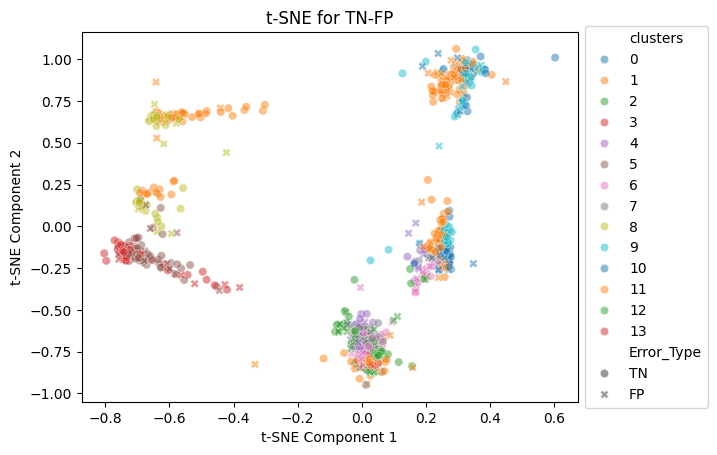

In [257]:
tsne_plot_wClusters(res_wSHAP['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

In [258]:
res_wSHAP_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light ,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

9  clusters were found:


In [259]:
res_wSHAP_wError['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
0,0,96,56,0.583,0.050,0.293,0.063,0.002,0.896,0.469,0.000,0.000,-0.395,0.001,0.000,-0.237,0.026
2,2,326,145,0.445,0.028,0.175,0.041,0.000,0.893,0.565,0.000,0.000,-0.479,0.000,0.000,-0.288,0.000
6,6,51,20,0.392,0.068,0.085,0.081,0.345,0.765,0.317,0.018,0.000,-0.382,0.012,0.000,-0.229,0.111
7,7,90,27,0.300,0.048,-0.011,0.061,0.853,0.889,0.459,0.000,0.000,-0.393,0.001,0.000,-0.236,0.032
1,1,73,20,0.274,0.052,-0.038,0.065,0.546,0.000,-0.485,0.000,0.712,0.364,0.002,1.000,0.822,0.000
3,3,84,20,0.238,0.046,-0.077,0.059,0.170,1.000,0.575,0.000,0.000,-0.391,0.001,1.000,0.829,0.000
5,5,69,14,0.203,0.048,-0.113,0.061,0.054,0.899,0.462,0.001,0.000,-0.387,0.004,1.000,0.819,0.000
4,4,354,78,0.220,0.022,-0.121,0.037,0.000,0.000,-0.615,0.000,0.797,0.574,0.000,0.234,0.018,0.543
8,8,255,54,0.212,0.026,-0.121,0.040,0.001,0.000,-0.562,0.000,0.706,0.414,0.000,0.000,-0.270,0.000


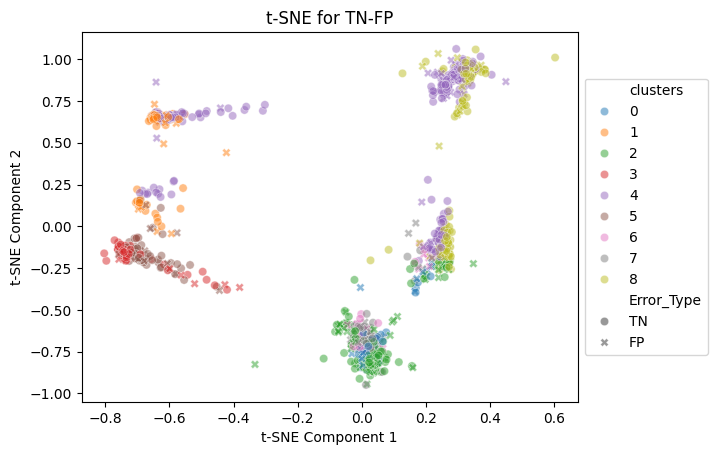

In [260]:
tsne_plot_wClusters(res_wSHAP_wError['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

## SHAP only (w/wo Error)

In [261]:
res_SHAPonly = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light ,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

1  clusters were found:


In [262]:
res_SHAPonly['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
0,0,1398,434,0.31,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


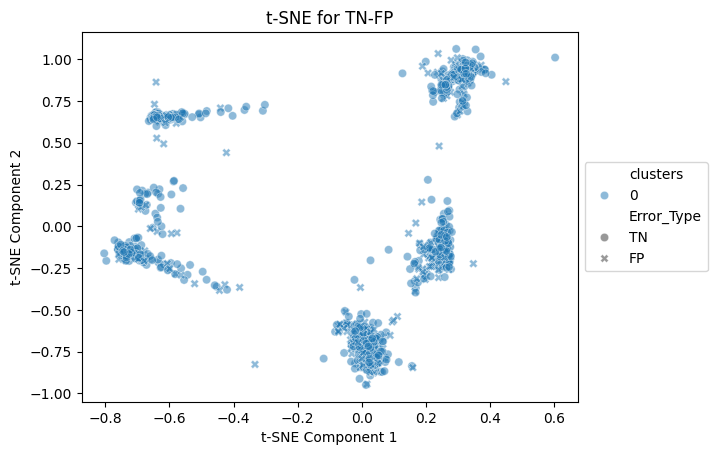

In [263]:
tsne_plot_wClusters(res_SHAPonly['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

In [264]:
res_SHAPonly_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light ,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

1  clusters were found:


In [265]:
res_SHAPonly_wError['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
0,0,1398,434,0.31,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


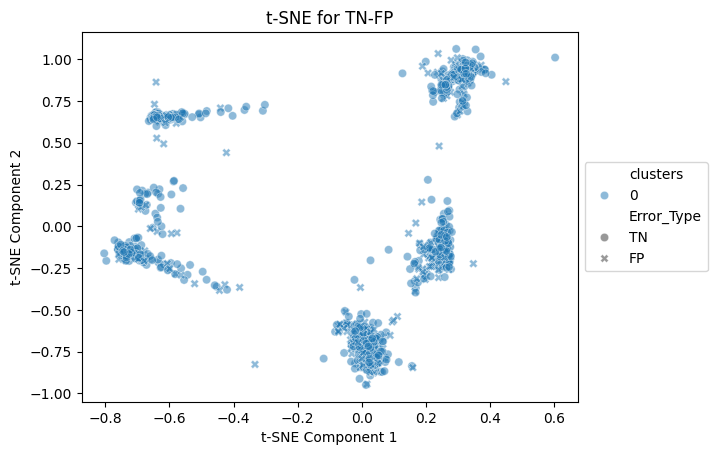

In [266]:
tsne_plot_wClusters(res_SHAPonly_wError['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

## Sensitive features only (gender, race)

### Baseline (w/wo Error)

In [267]:
res_SENSonly = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = DUMMY_COL_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

5  clusters were found:


In [268]:
res_SENSonly['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
2,2,496,210,0.423,0.022,0.175,0.037,0.000,1.000,0.838,0.0,0.0,-0.570,0.0,0.0,-0.343,0.000
4,4,122,33,0.270,0.040,-0.044,0.053,0.379,0.000,-0.503,0.0,1.0,0.693,0.0,1.0,0.853,0.000
3,3,201,53,0.264,0.031,-0.055,0.045,0.171,0.000,-0.536,0.0,0.0,-0.429,0.0,0.0,-0.258,0.001
0,0,392,99,0.253,0.022,-0.080,0.037,0.010,0.000,-0.638,0.0,1.0,0.879,0.0,0.0,-0.307,0.000
1,1,187,39,0.209,0.030,-0.118,0.043,0.003,0.781,0.371,0.0,0.0,-0.424,0.0,1.0,0.899,0.000


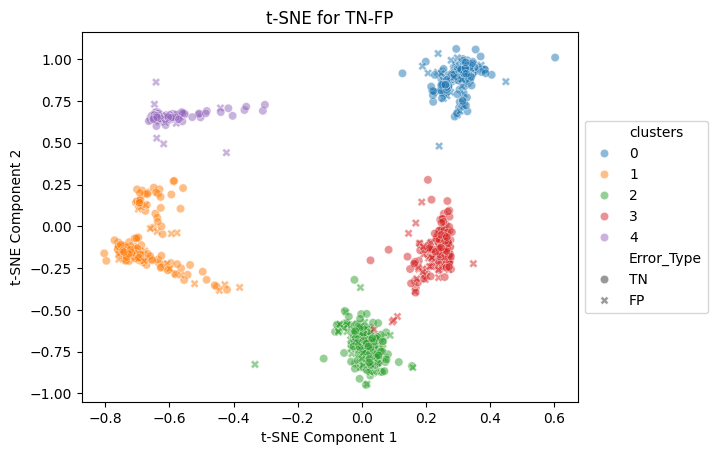

In [269]:
tsne_plot_wClusters(res_SENSonly['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

In [270]:
res_SENSonly_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + DUMMY_COL_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

9  clusters were found:


In [271]:
res_SENSonly_wError['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
4,4,182,81,0.445,0.037,0.155,0.050,0.004,1.000,0.622,0.000,0.0,-0.423,0.000,0.0,-0.254,0.002
5,5,314,129,0.411,0.028,0.129,0.041,0.001,1.000,0.697,0.000,0.0,-0.474,0.000,0.0,-0.285,0.000
8,8,75,21,0.280,0.052,-0.032,0.065,0.612,0.000,-0.485,0.000,0.0,-0.389,0.002,0.0,-0.234,0.051
6,6,122,33,0.270,0.040,-0.044,0.053,0.379,0.000,-0.503,0.000,1.0,0.693,0.000,1.0,0.853,0.000
7,7,253,67,0.265,0.028,-0.056,0.042,0.128,0.000,-0.561,0.000,1.0,0.772,0.000,0.0,-0.270,0.000
0,0,126,32,0.254,0.039,-0.062,0.052,0.195,0.000,-0.505,0.000,0.0,-0.404,0.000,0.0,-0.243,0.010
1,1,139,32,0.230,0.036,-0.089,0.049,0.045,0.000,-0.510,0.000,1.0,0.702,0.000,0.0,-0.245,0.007
3,3,118,27,0.229,0.039,-0.089,0.052,0.061,0.771,0.341,0.000,0.0,-0.402,0.000,1.0,0.851,0.000
2,2,69,12,0.174,0.046,-0.144,0.058,0.014,0.797,0.355,0.004,0.0,-0.387,0.004,1.0,0.819,0.000


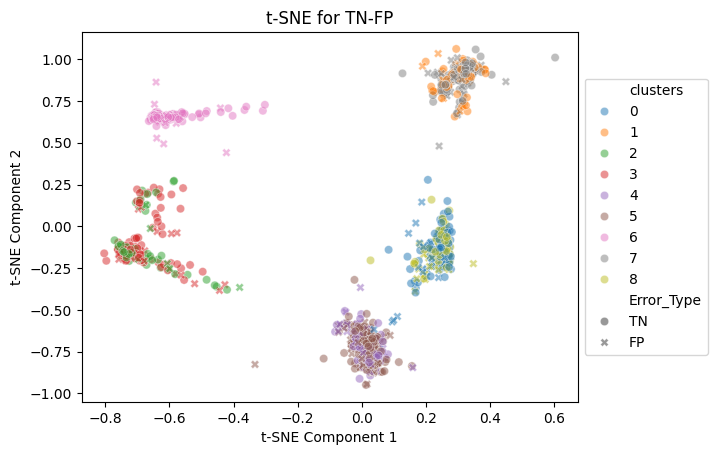

In [272]:
tsne_plot_wClusters(res_SENSonly_wError['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

### Regular + SHAP (w/wo Error)

In [273]:
res_SENSonly_wSHAP = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = DUMMY_COL_scaled_light + SHAP_DUMMY_scaled_light ,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

14  clusters were found:


In [274]:
res_SENSonly_wSHAP['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
7,7,57,29,0.509,0.066,0.207,0.079,0.042,1.000,0.564,0.001,0.0,-0.383,0.008,0.0,-0.230,0.091
8,8,47,22,0.468,0.073,0.163,0.085,0.118,1.000,0.560,0.002,0.0,-0.380,0.016,0.0,-0.229,0.126
3,3,389,145,0.373,0.025,0.086,0.039,0.015,0.725,0.368,0.000,0.0,-0.509,0.000,0.0,-0.306,0.000
6,6,43,16,0.372,0.074,0.064,0.086,0.504,1.000,0.558,0.003,0.0,-0.379,0.021,0.0,-0.228,0.144
0,0,75,25,0.333,0.054,0.024,0.067,0.727,0.000,-0.485,0.000,1.0,0.668,0.000,1.0,0.823,0.000
1,1,67,22,0.328,0.057,0.019,0.070,0.794,1.000,0.568,0.000,0.0,-0.386,0.004,0.0,-0.232,0.066
5,5,94,29,0.309,0.048,-0.002,0.060,0.973,0.000,-0.492,0.000,0.0,-0.394,0.001,0.0,-0.237,0.028
12,12,69,21,0.304,0.055,-0.006,0.068,0.927,0.000,-0.483,0.001,1.0,0.665,0.000,0.0,-0.233,0.062
10,10,55,16,0.291,0.061,-0.020,0.074,0.787,0.000,-0.478,0.002,1.0,0.658,0.000,0.0,-0.230,0.097
2,2,107,29,0.271,0.043,-0.043,0.056,0.421,0.785,0.353,0.000,0.0,-0.398,0.000,1.0,0.844,0.000


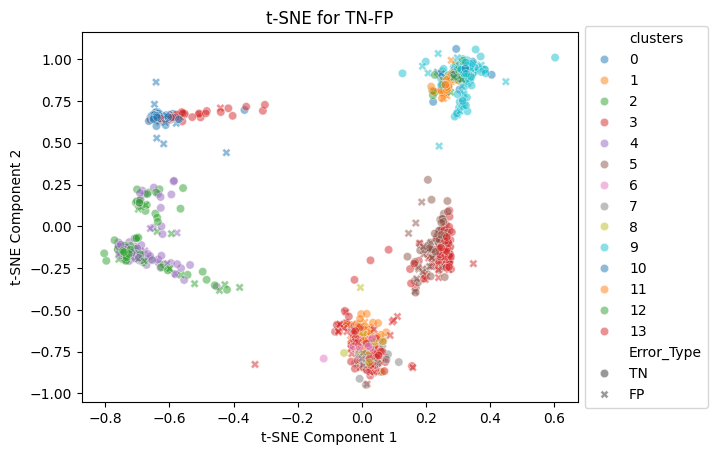

In [275]:
tsne_plot_wClusters(res_SENSonly_wSHAP['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

In [276]:
res_SENSonly_wSHAP_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + DUMMY_COL_scaled_light + SHAP_DUMMY_scaled_light ,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

13  clusters were found:


In [277]:
res_SENSonly_wSHAP_wError['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
5,5,110,49,0.445,0.047,0.147,0.060,0.030,0.682,0.242,0.005,0.0,-0.399,0.000,0.0,-0.240,0.017
7,7,93,38,0.409,0.051,0.105,0.064,0.127,1.000,0.579,0.000,0.0,-0.394,0.001,0.0,-0.237,0.029
2,2,242,92,0.380,0.031,0.084,0.045,0.050,0.723,0.319,0.000,0.0,-0.445,0.000,0.0,-0.267,0.000
12,12,147,53,0.361,0.040,0.056,0.053,0.283,0.728,0.300,0.000,0.0,-0.411,0.000,0.0,-0.247,0.005
0,0,46,15,0.326,0.069,0.016,0.082,0.852,1.000,0.559,0.002,0.0,-0.380,0.017,0.0,-0.229,0.130
1,1,112,35,0.312,0.044,0.002,0.057,0.968,0.000,-0.499,0.000,1.0,0.687,0.000,0.0,-0.240,0.016
11,11,88,24,0.273,0.047,-0.040,0.060,0.490,0.000,-0.490,0.000,1.0,0.675,0.000,0.0,-0.236,0.034
6,6,59,16,0.271,0.058,-0.041,0.071,0.558,0.000,-0.479,0.002,0.0,-0.384,0.007,0.0,-0.231,0.085
3,3,107,29,0.271,0.043,-0.043,0.056,0.421,0.785,0.353,0.000,0.0,-0.398,0.000,1.0,0.844,0.000
8,8,122,33,0.270,0.040,-0.044,0.053,0.379,0.000,-0.503,0.000,1.0,0.693,0.000,1.0,0.853,0.000


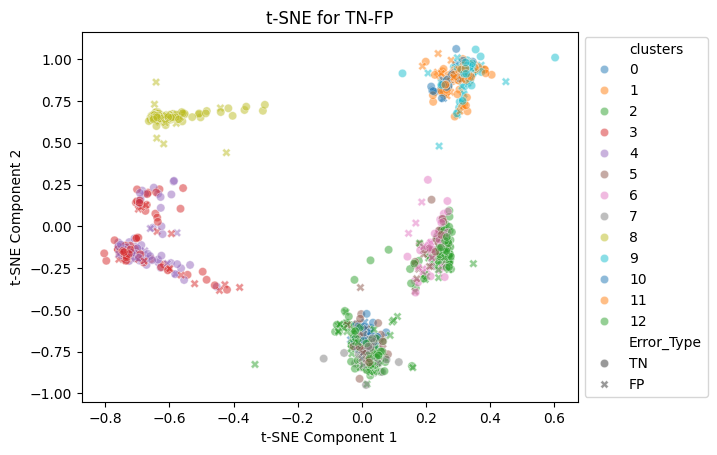

In [278]:
tsne_plot_wClusters(res_SENSonly_wSHAP_wError['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

### SHAP only (w/wo Error)

In [279]:
res_SENSonly_SHAPonly = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = SHAP_DUMMY_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

1  clusters were found:


In [280]:
res_SENSonly_SHAPonly['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
0,0,1398,434,0.31,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


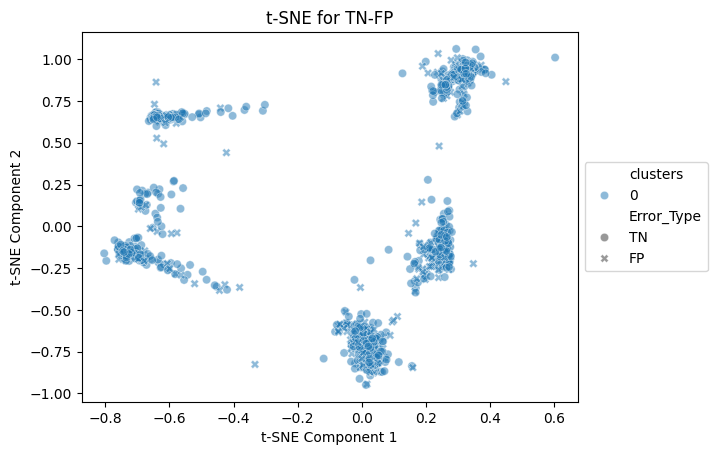

In [281]:
tsne_plot_wClusters(res_SENSonly_SHAPonly['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)

In [282]:
res_SENSonly_SHAPonly_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + SHAP_DUMMY_scaled_light ,
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

1  clusters were found:


In [283]:
res_SENSonly_SHAPonly_wError['recap'].sort_values(by=['diff_vs_rest'], ascending=False)

,c,count,n_error,error_rate,std,diff_vs_rest,diff_std,diff_p,race_aa_prop,race_aa_diff,race_aa_p,race_c_prop,race_c_diff,race_c_p,female_prop,female_diff,female_p
0,0,1398,434,0.31,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


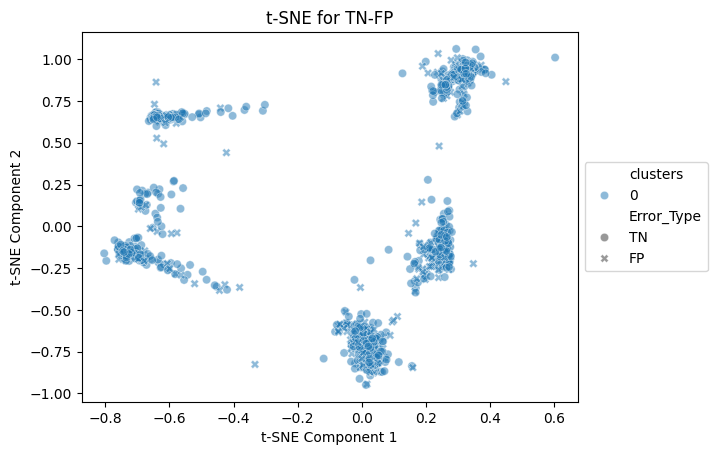

In [284]:
tsne_plot_wClusters(res_SENSonly_SHAPonly_wError['res'], title='t-SNE for TN-FP', alpha = 0.5,
          tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
          perplexity = 30, learning_rate = 200, n_iter = 250)